# Robinhood 5-day Account Growth Factor Analysis


**Disclaimer**

Any information provided by me on in this document is my opinion and is for informational purposes only. It does not necessarily reflect the views of my employer. All efforts have been made to report true and accurate information. However, the information could become materially inaccurate warning. Any opinions expressed herein are subject to change. None of this information is intended to be used as a primary basis of an investment decision, nor should it be construed as advice or a recommendation.

#### Sample
- **Data Source**: https://robintrack.net/data-download
- **Full Sample Period**:   May 5, 2018 to May 24, 2020
- **In-Sample Period**:     May 5, 2018 to May 31, 2019
- **Out-of-Sample Period**: July 1, 2019 to May 24, 2020

#### Summary of Key Points
- Robinhood is a fast growing FINRA broker dealer whose clients are relatively inexperienced, yet trade actively. It has a popular trading app and was a pioneer in commission free trading.
- Data from [Robintrack.net](https://robintrack.net) tracks the number of Robinhood accounts that hold a given stock.
- A 5-day long-short account growth factor (i.e. the percent change in number of accounts holding the stock) appears to show positive alpha over the next 1 to 5 trading days. However, performance does deteriorate in the out-of-sample period, but exceptional market volatility makes it difficult to determine whether this deterioration was simply a result of a difficult market regime, or if it was due to overfitting and/or signal decay.
- There is evidence that the source of alpha could be a result of a herding mentality where Robinhood users visually see which stocks are “trending” in the app, and then pile on, leading to a momentum effect.
- The factor does show some exposure to the short term mean reversion factor, suggesting Robinhood traders may have a tendency to buy beaten down names.
- Results are noisy, and should be looked at skeptically, especially given the relatively short sample period (2 years). The factor alone is not likely to be robust on its own. Combination with other complimentary factors is likely necessary. 

#### Robinhood Background

Robinhood is a fast growing FINRA broker dealer company whose commission free trading app has attracted a large number of new retail traders. In May, Robinhood said it had 13 million accounts, which was up from 10 million at the end of 2019 (Source: https://www.nytimes.com/2020/07/08/technology/robinhood-risky-trading.html). Its customers reportedly are relatively inexperienced, yet tend to trade more frequently and aggressively. According to the above New York Times article, “In the first three months of 2020, Robinhood users traded nine times as many shares as E-Trade customers, and 40 times as many shares as Charles Schwab customers, per dollar in the average customer account in the most recent quarter. They also bought and sold 88 times as many risky options contracts as Schwab customers, relative to the average account size...” The app is also said to encourage more trading through techniques such as push notifications.

#### Hypothesis
As a result of increased user growth and the aggressive trading of these users, Robinhood traders have a potential increasing influence on market prices. [Robintrack.net](https://robintrack.net) is a site that tracks the number of Robinhood accounts that hold a certain security. In the notebook below, I used the data from Robintrack to create a Robinhood Account Growth Factor. It simply calculates the 5-day growth in accounts holding a particular security and ranks each stock in the universe based on this metric. The idea is that there may be a positive feedback loop as part of a popularity mechanism; whereas, once a stock gets popular on the platform, other users see this through the “trending tickers” widget, and they start to pile into the name as well. 

#### Universe Selection
The study uses the QTradeableStocksUS universe, which is a U.S. equity universe that filters for liquidity among some other factors. I also filter out closed end funds that have slipped through in the past. See the [Quantopian documentation](https://www.quantopian.com/docs/api-reference/pipeline-api-reference#quantopian.pipeline.filters.QTradableStocksUS) for more detail on the universe filtering criteria.

#### Discussion of Results
The results of this analysis do suggest that Robinhood account growth is positively correlated with short term returns over the next week or so. That said, the results may lack robustness as the sample period is very short. The in-sample period spanned about a year (May 5, 2018 to May 31, 2019 ), while the out-of-sample period was just under a year (July 1, 2019 to May 24, 2020). In the in-sample period, I tested 1, 5, 10, and 20-day percent changes in accounts before settling on the 5-day growth factor. It is noteable that the other parameters did have moderately positive results as well.  

Performance declined in the out-of-sample period. Unsurprisingly, the returns also became more volatile as overall market volatility picked up substantially. The underperformance during the selloff might suggest that these “popular robinhood” stocks may suffer from an unwinding of positions during volatile times. This exceptional volatility in the out-of-sample period also makes it particularly difficult to disentangle the source of performance decay. It could have been a result of a difficult market regime for the strategy, or it could have been a result of in-sample over-fitting and/or signal arbitrage/decay. 

Despite this trade thesis being based on the concept of momentum in popularity, the performance attribution results suggest a portion of the returns are explained by a positive exposure to the short term mean reversion factor. This aligns with anecdotal evidence that these traders have been prone to buy low priced, beaten up names. Robinhood co-founder and co CEO Vladimir Teneve was quoted by CNBC, “We see a lot of buying activity of specifically industries that were impacted by the pandemic.” Investors traded “a lot in airlines, a decent amount of buying in videoconferencing, streaming services, some biopharmacuetical as well,” (https://www.cnbc.com/2020/06/09/robinhood-traders-cash-in-on-the-market-comeback-that-billionaire-investors-missed.html). That said, specific returns not attributable to common factors appear to be the main driver of alpha. 

All analysis was done ignoring commissions or market impact. The goal was to get a sense for the strength of the signal of this single factor and not as a completed trading strategy. 

#### Topics for Future Work

- Study possible regime filters based on volatility.
- Monitor whether exposure to mean reversion factor is stable, or if it was just an artifact of the crisis. 
- Combine and analyze interaction with other complimentary factors.
- Search for a mean reversion strategy with the idea that momentum as a result of "uninformed traders" is likely to mean revert after the initial impact of robinhood traders piling on.



In [1]:
from collections import OrderedDict
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import alphalens as al
# Typical imports for use with Pipeline
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.research import run_pipeline

# New way: Fundamentals.my_field:
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.filters import QTradableStocksUS

from quantopian.pipeline.data.user_57bcf8e194cdba3f02000188 import rh_weekdays_only as rh

### Helper Functions

Shoutout to Joakim Arvidsson as I did borrow a portion of his code in the `summarize_null_records` function below.

In [2]:
def summarize_null_records(result):
    """Utility Function to Summarize NaN Values"""
    null_summary =pd.DataFrame()
    null_summary["null_records"]=result.isnull().sum()
    null_summary["not_null"]=result.notnull().sum()
    null_summary["total"]=result.isnull().sum()+result.notnull().sum()
    null_summary["null_records/total"]=null_summary["null_records"]/null_summary["total"]

    symbol_count_by_day = result.groupby(level=0).count()

    null_count_by_day = result.isnull().groupby(level=0).sum()
    pct_null_by_day = null_count_by_day / symbol_count_by_day

    display(null_summary)
    pct_null_by_day.plot(title="% of Symbols with Null Values by Date");

    
def get_al_prices(result, periods):
    assets = result.index.get_level_values(1).unique()
    start_date = result.index.get_level_values(0)[0]
    end_date = (result.index.get_level_values(0)[-1]  + max(periods) *
                pd.tseries.offsets.BDay() + pd.Timedelta(days=5))
    pricing = get_pricing(assets, start_date, end_date, fields="open_price")
    return pricing


### Factor Definition

In [3]:
def _make_RHAcctGrowth_factor(lookback_days):
    """Make Custom Factors that calculate the growth in Robinhood
    Accounts over the last `lookback_days` days.
    
    Params
    ------
    lookback_days: int
    
    Returns
    """
    class RHAcctGrowth(CustomFactor):
        inputs = [rh.accounts]
        window_length = lookback_days + 1
    
        def compute(self, today, asset_ids, out, accounts):
            out[:] = accounts[-1] / accounts[0] - 1
    
    return RHAcctGrowth

def make_RHAcctGrowth_factors(lookback_list=[1,3,5,10,20], rank=False, **factor_kwargs):
    """Construct a bunch of RH_AcctGrowth_factors with given
    lookback days. Returns a dictionary containing the factores"""
    
    factors=OrderedDict()
    
    for lookback_days in lookback_list:
        label='rh_growth_{}'.format(lookback_days)
        if rank:
            label += '_rank'
            factors[label] = _make_RHAcctGrowth_factor(lookback_days)(**factor_kwargs).rank()
            
        else:
            factors[label] = _make_RHAcctGrowth_factor(lookback_days)(**factor_kwargs)
    
    return factors

In [4]:
def make_pipeline(base_universe = QTradableStocksUS()):
    closed_end_funds = Fundamentals.share_class_description.latest.startswith('CE')
    universe = base_universe & ~closed_end_funds
    
    factors = make_RHAcctGrowth_factors(lookback_list=[5],  mask=universe)
    factors.update(make_RHAcctGrowth_factors(lookback_list=[5], rank=True, mask=universe))    
    factors['rh_accounts'] = rh.accounts.latest
    
    return Pipeline(columns=factors, screen=universe)


### In-Sample Alphalens Tearsheet

**Sample Dates**: June 5, 2018 through May 31, 2019

In [5]:
start_date = pd.datetime(2018,6,5)
end_date = pd.datetime(2019,5,31)
result = run_pipeline(make_pipeline(), start_date, end_date, chunksize=525)
result = result.replace([np.inf, -np.inf], np.nan)

In [6]:
result.head()

rh_accounts  rh_growth_5  \
2018-06-05 00:00:00+00:00 Equity(2 [HWM])         2091.0    -0.009943   
                          Equity(24 [AAPL])     142084.0    -0.000267   
                          Equity(31 [ABAX])         36.0    -0.052632   
                          Equity(41 [ARCB])         72.0    -0.040000   
                          Equity(52 [ABM])         145.0     0.058394   

                                             rh_growth_5_rank  
2018-06-05 00:00:00+00:00 Equity(2 [HWM])               599.0  
                          Equity(24 [AAPL])             796.0  
                          Equity(31 [ABAX])             100.0  
                          Equity(41 [ARCB])             166.0  
                          Equity(52 [ABM])             1794.0

null_records  not_null   total  null_records/total
rh_accounts              47230    505047  552277            0.085519
rh_growth_5              48088    504189  552277            0.087072
rh_growth_5_rank         48079    504198  552277            0.087056

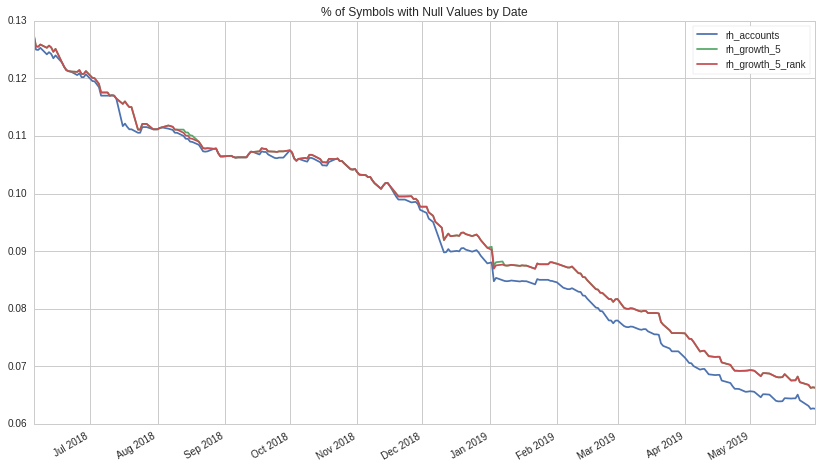

In [7]:
summarize_null_records(result) 

Null values become less of a problem through time. As total robinhood accounts grow over time so will the breadth of stocks that customers own. 

#### Autocorrelation Study

The below chart is actually included in the full alphalens tearsheet, but I wanted to isolate it because part of my thesis is that the account growth factor values themselves will be autocorrolated. In other words, as users see other robinhood users buying a stock, it will encourage them to buy the stock as well. 

The code below calculates the factor autocorrelation lagged by 5 days. There does seem to be a significant positive autocorrelation, which supports my hypothesis. 

Mean Autocorrelation(5) = 0.099


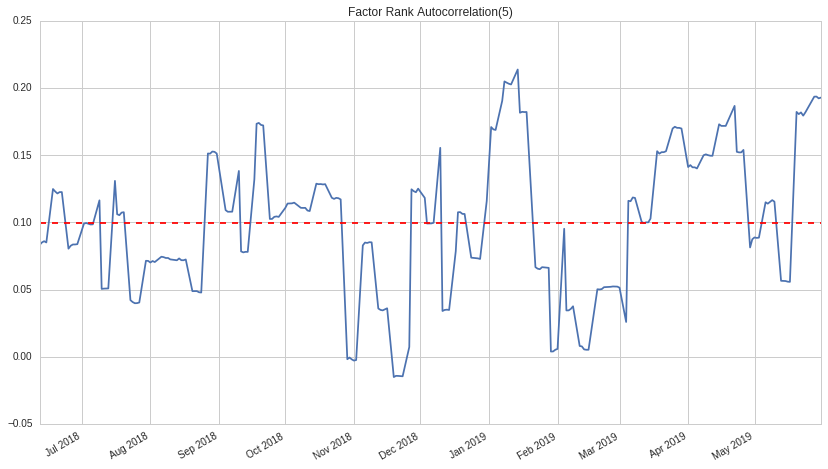

In [8]:
growth_rank = result.rh_growth_5_rank.unstack()[5:]
growth_rank_lagged = result.rh_growth_5_rank.unstack().shift(5)[5:]

auto_corr_results = {}
for date, ranks in growth_rank.iterrows():
    auto_corr_results[date] = \
        pd.concat([ranks, growth_rank_lagged.loc[date]], axis=1).corr().iloc[0,1]
    
auto_corr_s = pd.Series(auto_corr_results)
auto_corr_s.plot(title='Factor Rank Autocorrelation(5)')
plt.axhline(auto_corr_s.mean(), color='r', ls='--');
print("Mean Autocorrelation(5) = {:0.3f}".format(auto_corr_s.mean()))

In [9]:
periods = [1,3,5,10]
quantiles=5

prices = get_al_prices(result, periods)

factor_data_rh = \
    al.utils.get_clean_factor_and_forward_returns(
        result['rh_growth_5_rank'], 
        prices,
        quantiles=quantiles,
        periods=periods)

Dropped 8.8% entries from factor data: 8.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### Alphalens In-Sample Tearsheet Commentary

The mean quintile return distribution is monotonically increasing up until the last quintile. This could be noise, but it could also indicate that at the extremes of the distribution, some mean reversion might be taking place as a result of a large number of "uninformed and unsophisticated traders" push price past any reasonable fundamental value. 

Something that I did not really dig into was the alpha decay/optimal holding period. This was largely intentional as I was not confident there was enough data in the sample to really determine this. However, it could be an area of future research, particularly to see if mean reversion happens at a certain point.

Quantiles Statistics


min     max         mean         std   count    count %
factor_quantile                                                            
1                   1.0   412.0   203.361614  117.109637  100845  20.020488
2                 396.0   820.0   608.607675  116.932222  100692  19.990113
3                 791.0  1226.0  1013.355056  117.045355  100694  19.990510
4                1186.0  1634.0  1418.039814  117.232241  100692  19.990113
5                1581.0  2043.0  1822.963209  117.573997  100786  20.008775

Returns Analysis


1D     3D     5D    10D
Ann. alpha                                     0.052  0.047  0.044  0.036
beta                                          -0.005  0.010  0.022  0.016
Mean Period Wise Return Top Quantile (bps)     0.897  0.925  0.928  0.433
Mean Period Wise Return Bottom Quantile (bps) -3.041 -2.618 -2.457 -2.196
Mean Period Wise Spread (bps)                  3.938  3.540  3.382  2.627

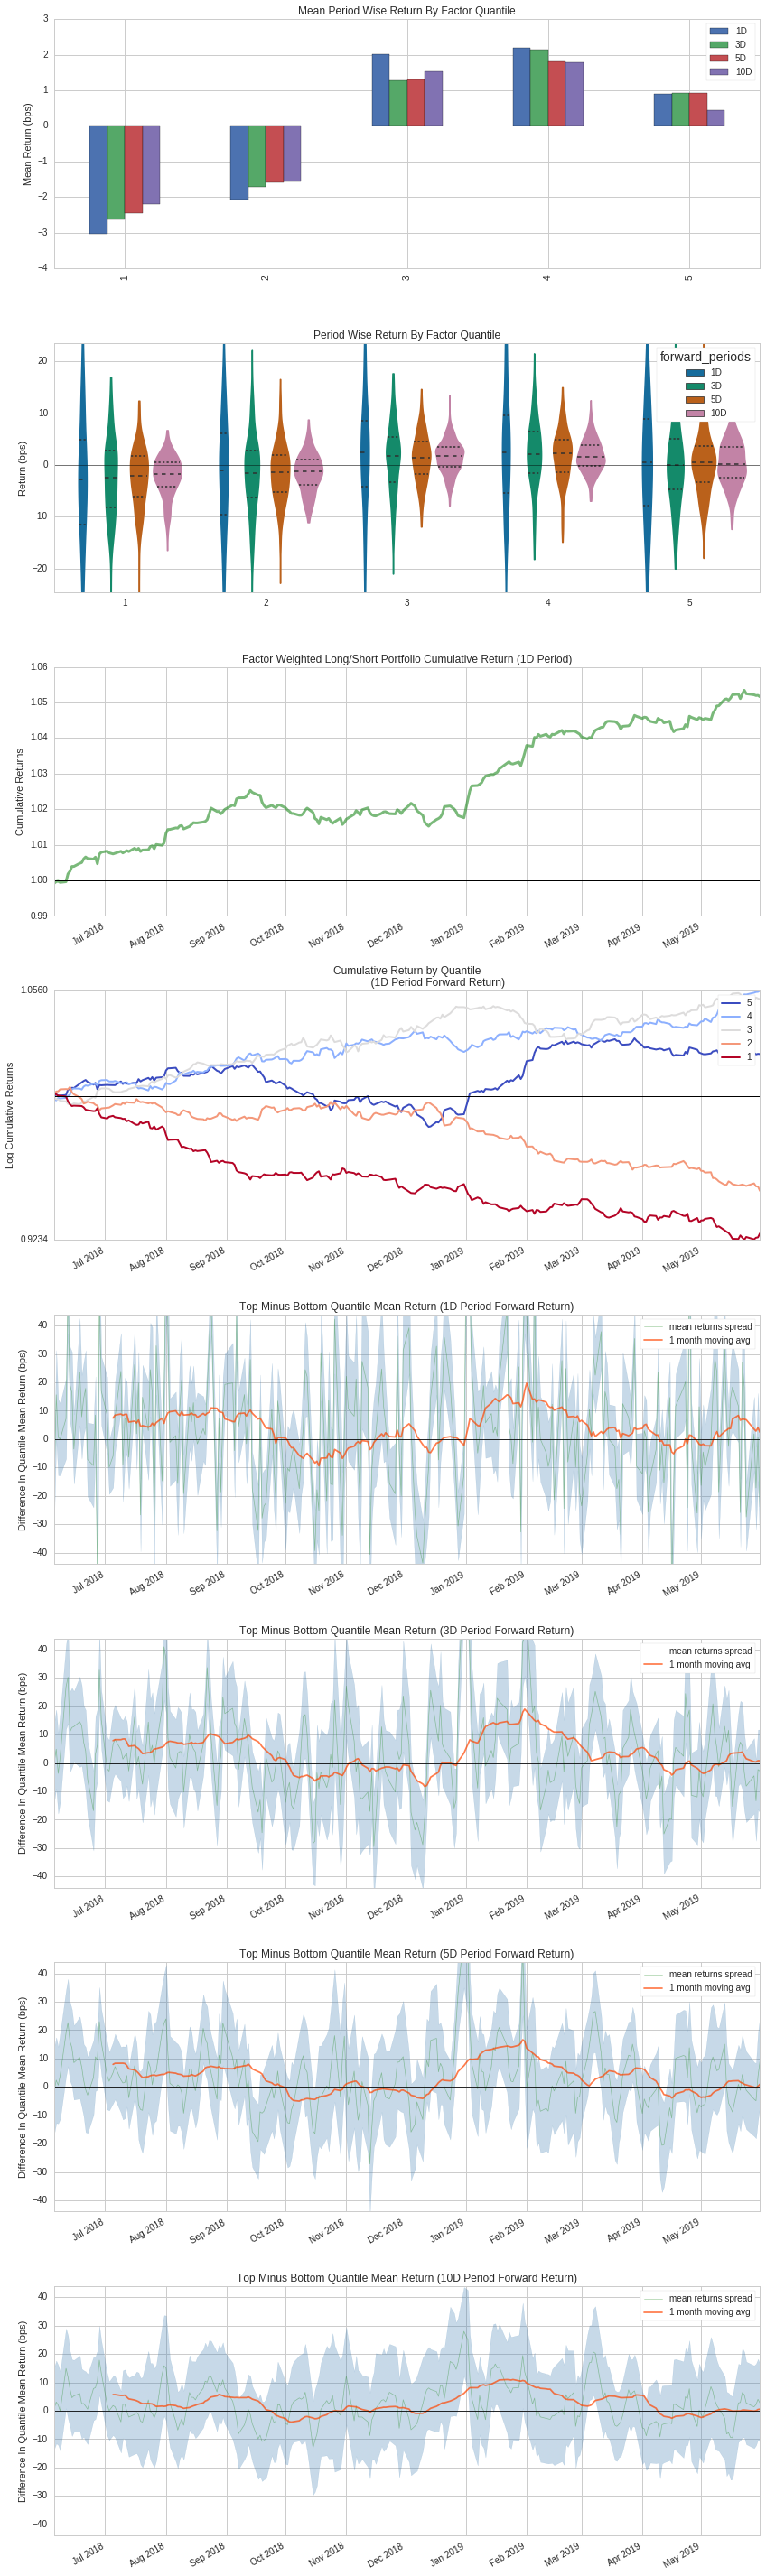

Information Analysis


1D     3D     5D    10D
IC Mean           0.007  0.012  0.015  0.018
IC Std.           0.041  0.044  0.041  0.035
Risk-Adjusted IC  0.176  0.274  0.374  0.514
t-stat(IC)        2.770  4.320  5.909  8.109
p-value(IC)       0.006  0.000  0.000  0.000
IC Skew           0.359  0.274  0.107  0.321
IC Kurtosis       0.368  0.822  0.713  0.080

/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


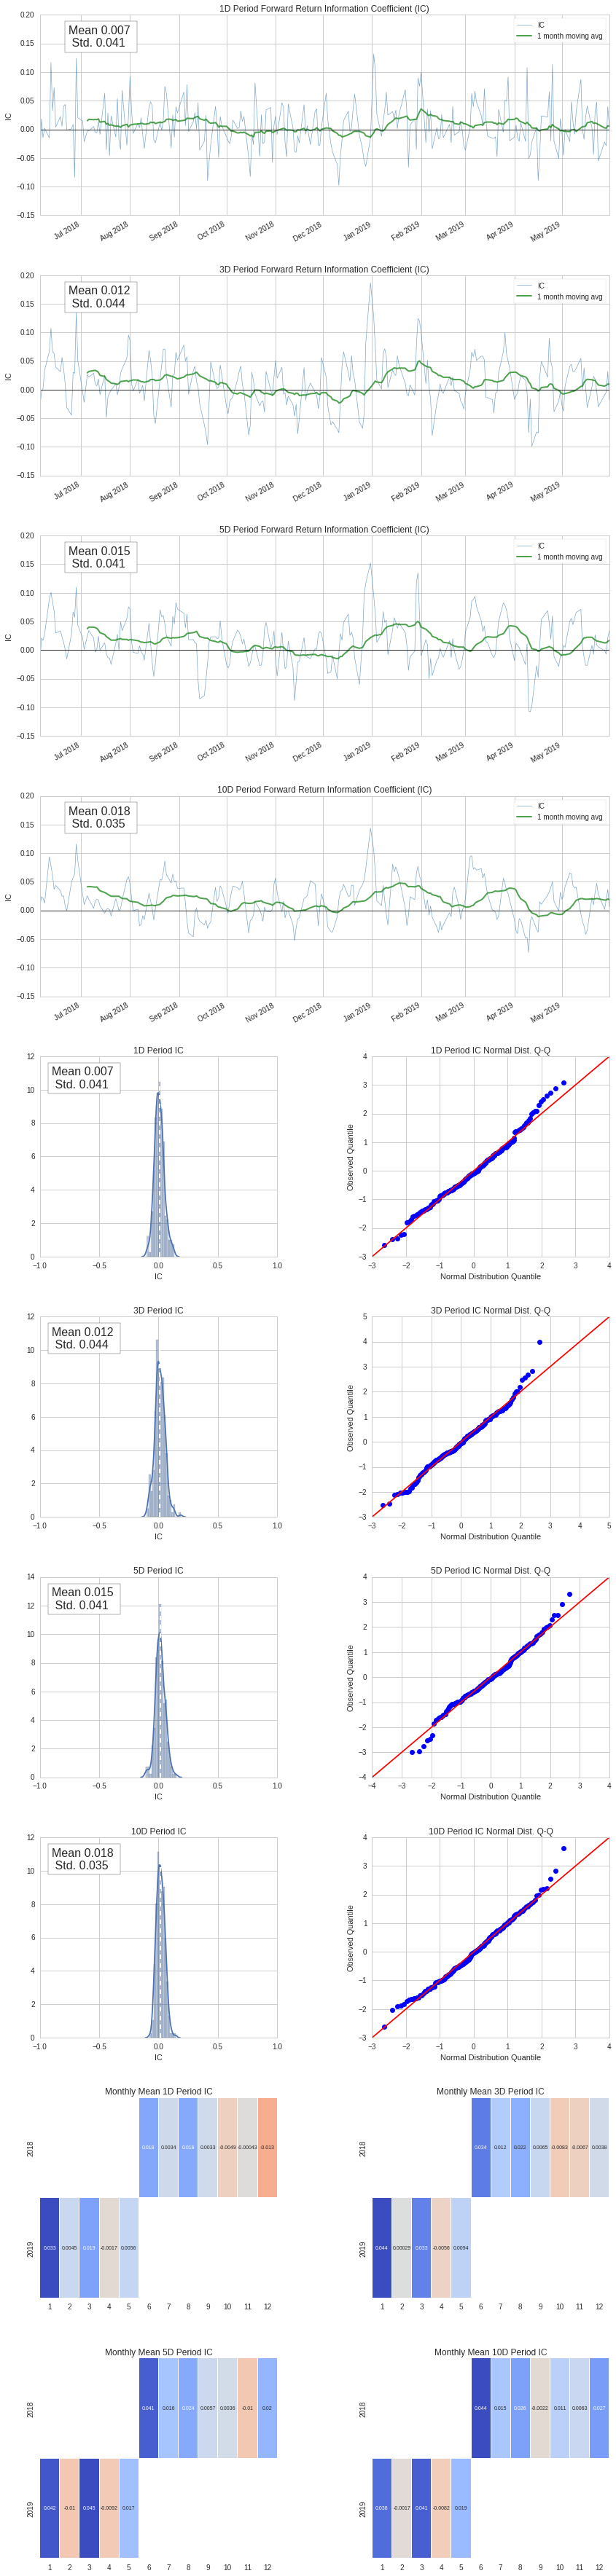

/venvs/py35/lib/python3.5/site-packages/alphalens/utils.py:912: UserWarning: Skipping return periods that aren't exact multiples of days.
  + " of days."


Turnover Analysis


1D     3D     5D    10D
Quantile 1 Mean Turnover   0.148  0.443  0.708  0.716
Quantile 2 Mean Turnover   0.162  0.458  0.714  0.736
Quantile 3 Mean Turnover   0.170  0.477  0.740  0.758
Quantile 4 Mean Turnover   0.167  0.476  0.741  0.747
Quantile 5 Mean Turnover   0.148  0.444  0.711  0.739

1D     3D     5D    10D
Mean Factor Rank Autocorrelation  0.824  0.448  0.099  0.084

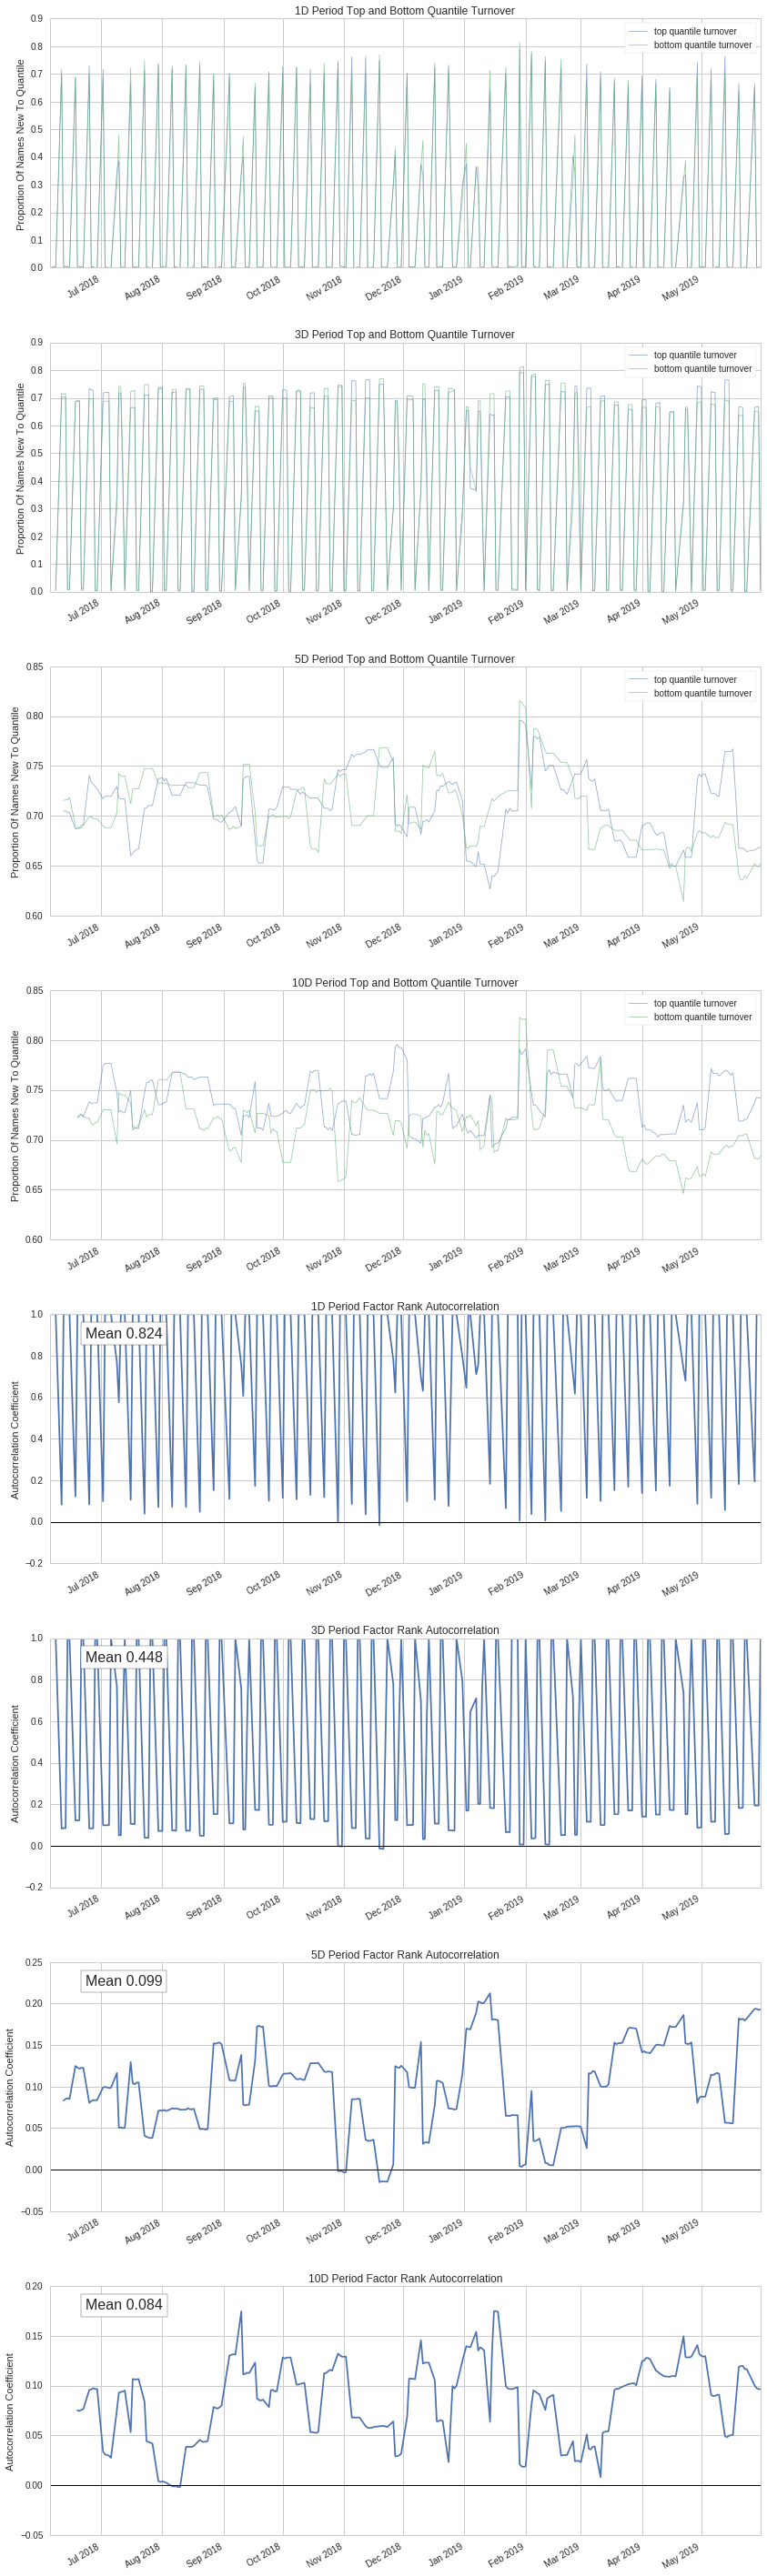

In [10]:
al.tears.create_full_tear_sheet(factor_data_rh)

### Out of Sample Alphalens Tearsheet Study

July 1, 2019 to May 24, 2020

(Note, I left a month buffer between in-sample and out-of-sample periods to prevent any information leakage.)

For brevity, I have used the summary tearsheet for the out-of-sample period. More info on the out-of-sample period can be seen in the Pyfolio tearsheet below.

In [11]:
start_date = pd.datetime(2019,7,1)
end_date = pd.datetime(2020,5,24)
result_o = run_pipeline(make_pipeline(), start_date, end_date, chunksize=525)
result_o = result_o.replace([np.inf, -np.inf], np.nan)

In [12]:
periods = [1,3,5,10]
quantiles=5

prices_o = get_al_prices(result_o, periods)

factor_data_rh_o = \
    al.utils.get_clean_factor_and_forward_returns(
        result_o['rh_growth_5_rank'], 
        prices_o,
        quantiles=quantiles,
        periods=periods)

Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


#### Out-of-sample Commentary

Performance did deteriorate out of sample. Alpha declined while information coefficients shrunk toward 0. Noteably, beta increased slightly along with market volatility which is not a desirable characteristic of the factor (i.e. We don't want the market beta to increase when market is going down).

I think the exceptional market volatility in the out-of-sample period makes it particularly difficult to disentangle the drivers of performance deterioration. It could just be a difficult environment for the strategy. It could also be a result of overfitting in the sample period, or it could be decay of the signal from arbitrage. 

Quantiles Statistics


min     max         mean         std  count    count %
factor_quantile                                                           
1                   1.0   426.0   207.462315  119.528609  94176  20.019557
2                 406.0   848.0   620.745876  119.498407  94033  19.989159
3                 810.0  1271.0  1033.469502  120.006526  94040  19.990647
4                1214.0  1694.0  1446.163730  120.841783  94033  19.989159
5                1618.0  2117.0  1859.205581  122.014472  94138  20.011479

Returns Analysis


1D     3D     5D    10D
Ann. alpha                                     0.012  0.035  0.025  0.023
beta                                           0.119  0.141  0.127  0.045
Mean Period Wise Return Top Quantile (bps)     0.681  2.734  2.405  1.999
Mean Period Wise Return Bottom Quantile (bps) -1.034 -1.535 -0.935 -0.752
Mean Period Wise Spread (bps)                  1.715  4.128  3.205  2.719

Information Analysis


1D     3D     5D    10D
IC Mean          -0.004  0.002  0.003  0.008
IC Std.           0.079  0.094  0.095  0.072
Risk-Adjusted IC -0.049  0.021  0.032  0.105
t-stat(IC)       -0.746  0.310  0.482  1.586
p-value(IC)       0.456  0.757  0.630  0.114
IC Skew           0.347  0.526  0.479 -0.287
IC Kurtosis       2.304  2.758  2.446  2.614

Turnover Analysis


1D     3D     5D    10D
Quantile 1 Mean Turnover   0.138  0.406  0.652  0.676
Quantile 2 Mean Turnover   0.160  0.445  0.697  0.724
Quantile 3 Mean Turnover   0.169  0.469  0.730  0.750
Quantile 4 Mean Turnover   0.160  0.449  0.704  0.726
Quantile 5 Mean Turnover   0.134  0.396  0.640  0.681

1D     3D     5D    10D
Mean Factor Rank Autocorrelation  0.848  0.531  0.226  0.189

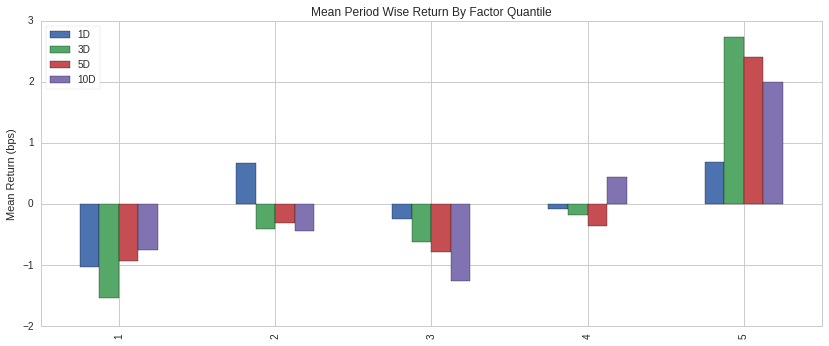

In [13]:
al.tears.create_summary_tear_sheet(factor_data_rh_o)

### Pyfolio Tearsheet for Full Sample Period

The backtest was run on an equal-weighted long-short strategy of the top/bottom 20% of names based on the above factor. It was run at 200% gross leverage (100% on each side), and was rebalanced daily 1 hour after the open. Commissions and slippage were set to 0, while the benchmark was the short term treasury ETF (SHY). 

The most significant factor exposure was to the short term reversal factor which contributed positively to performance, while secondarily, exposure to value detracted as value performed poorly over the period. 

In [14]:
bt = get_backtest('5edd2818383612473d6eb3a9')

100% Time:  0:00:42|##########################################################|


/venvs/py35/src/pyfolio/pyfolio/perf_attrib.py:612: UserWarning: This algorithm has relatively high turnover of its positions. As a result, performance attribution might not be fully accurate.

Performance attribution is calculated based on end-of-day holdings and does not account for intraday activity. Algorithms that derive a high percentage of returns from buying and selling within the same day may receive inaccurate performance attribution.

  warnings.warn(warning_msg)


## Performance Relative to Common Risk Factors

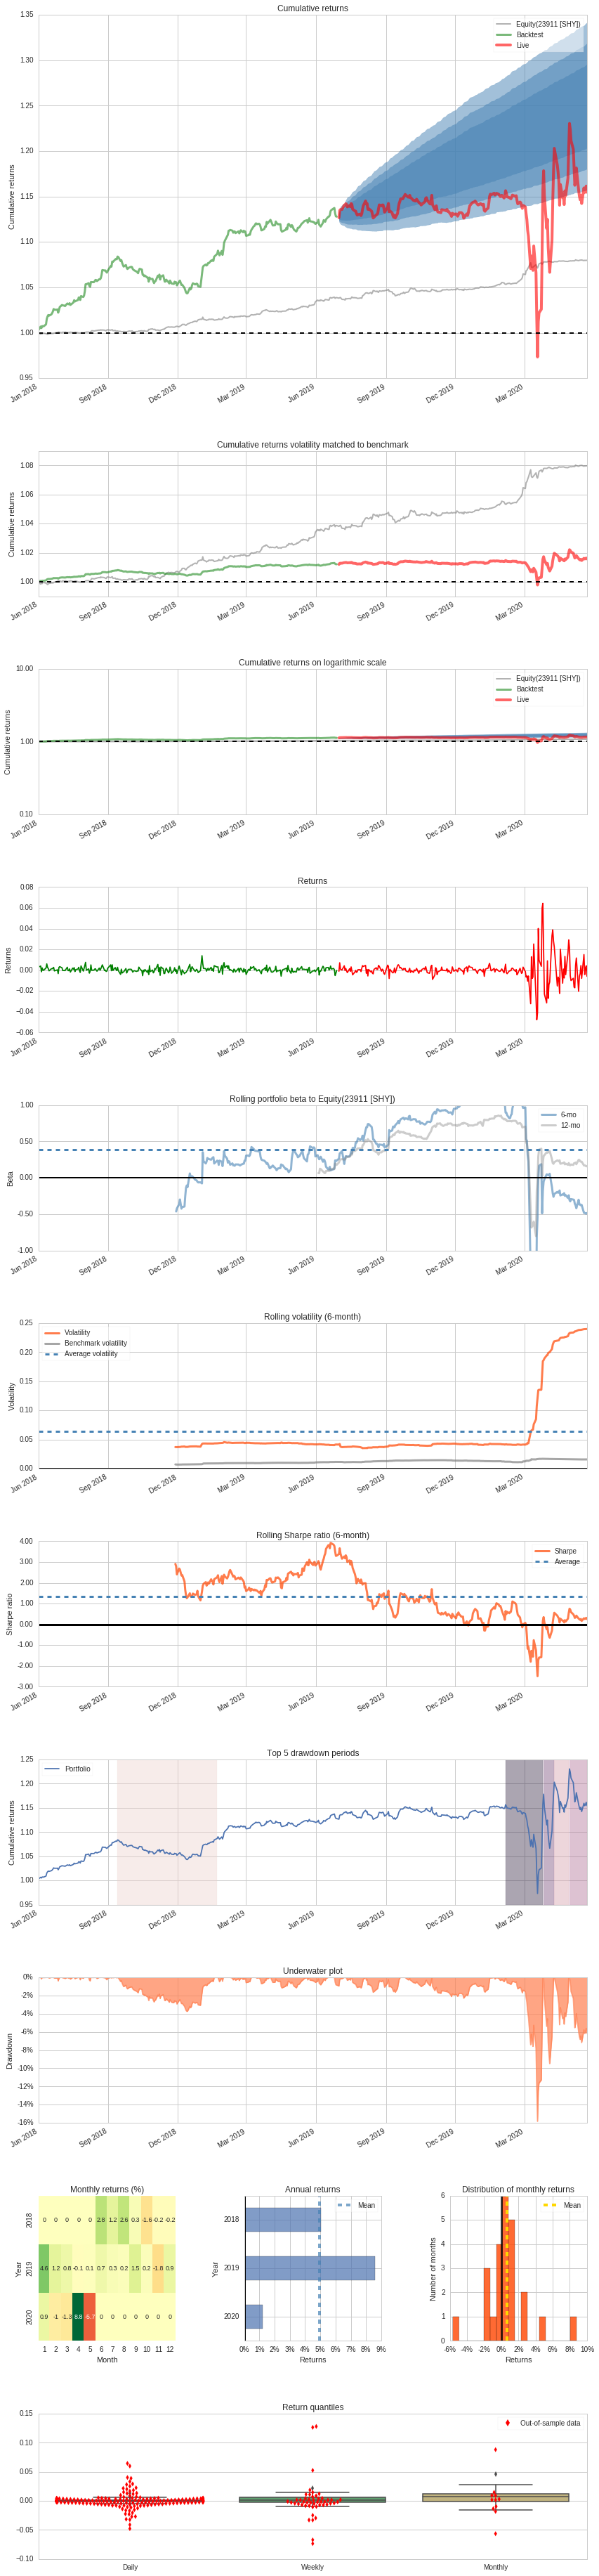

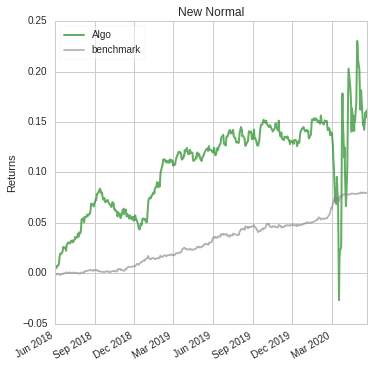

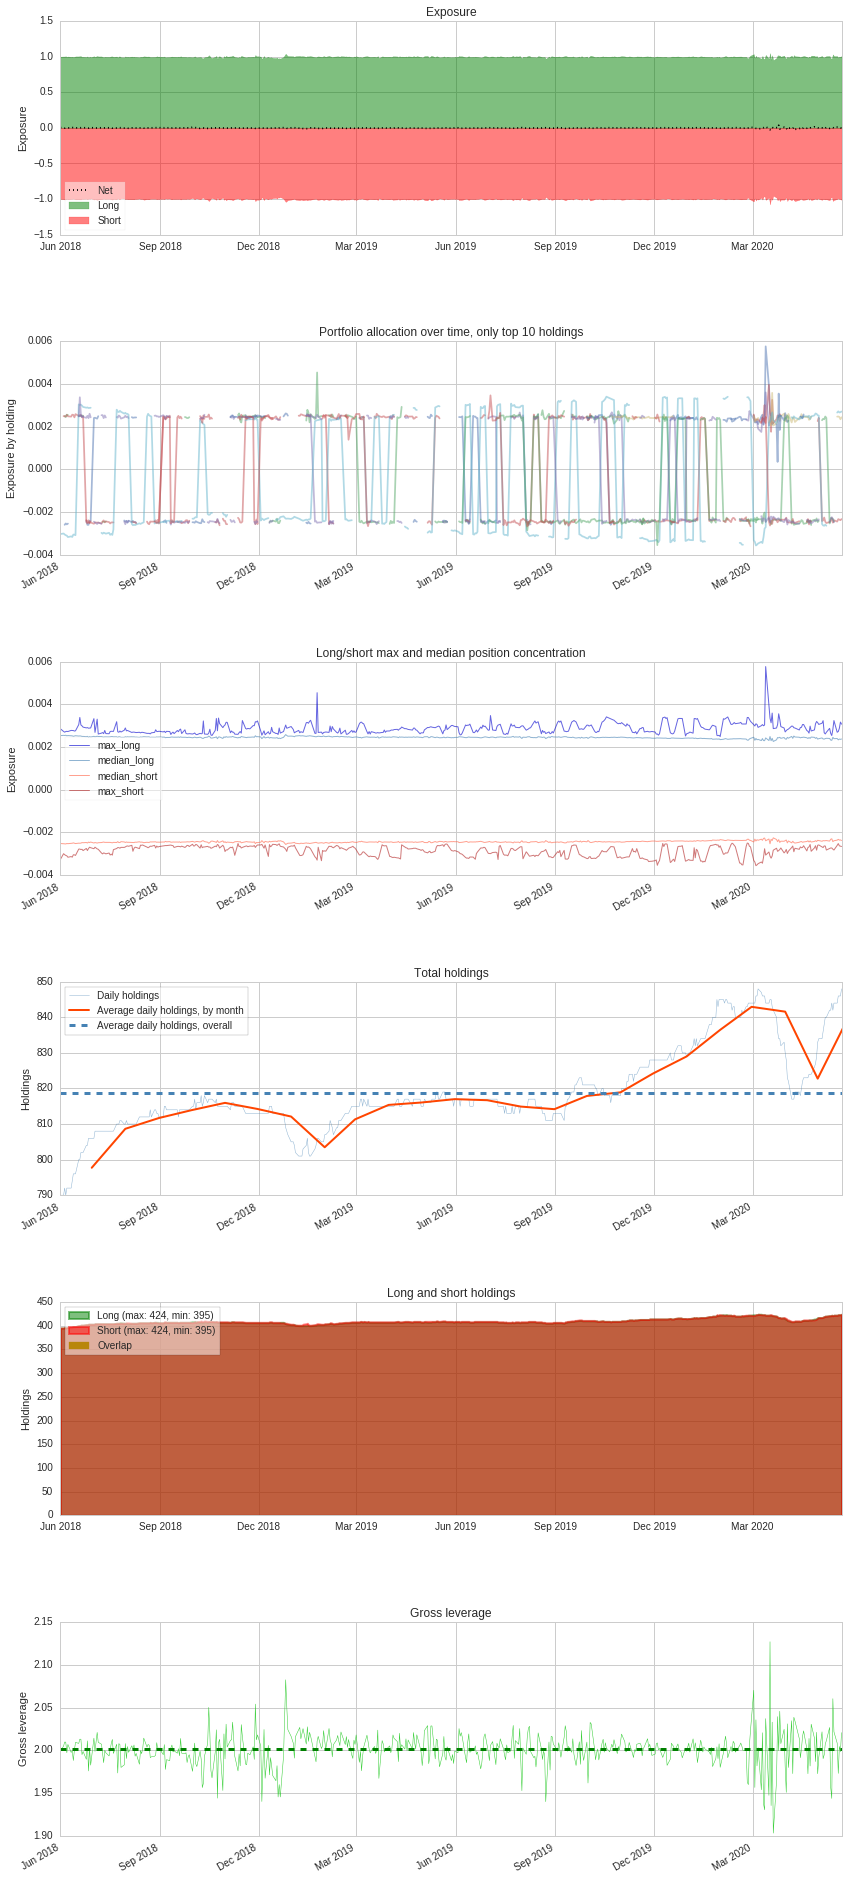

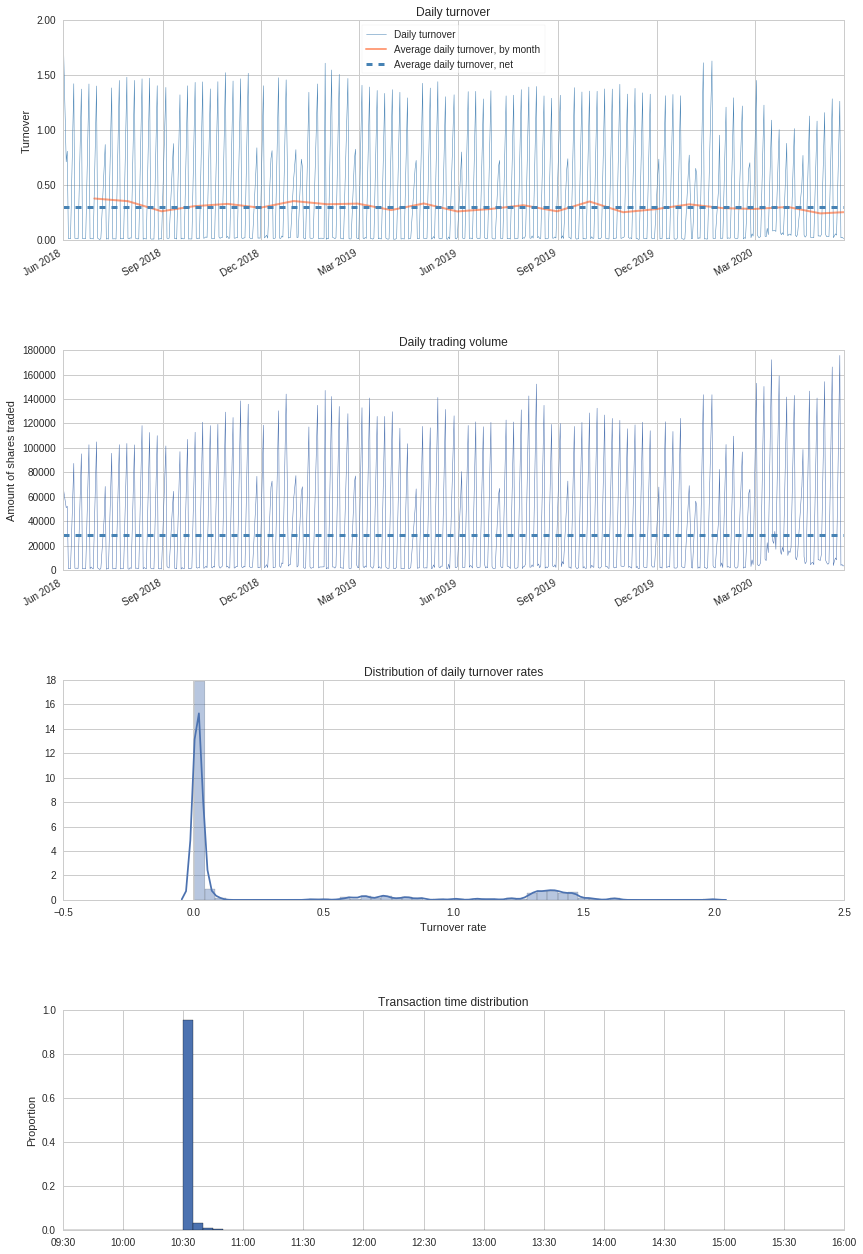

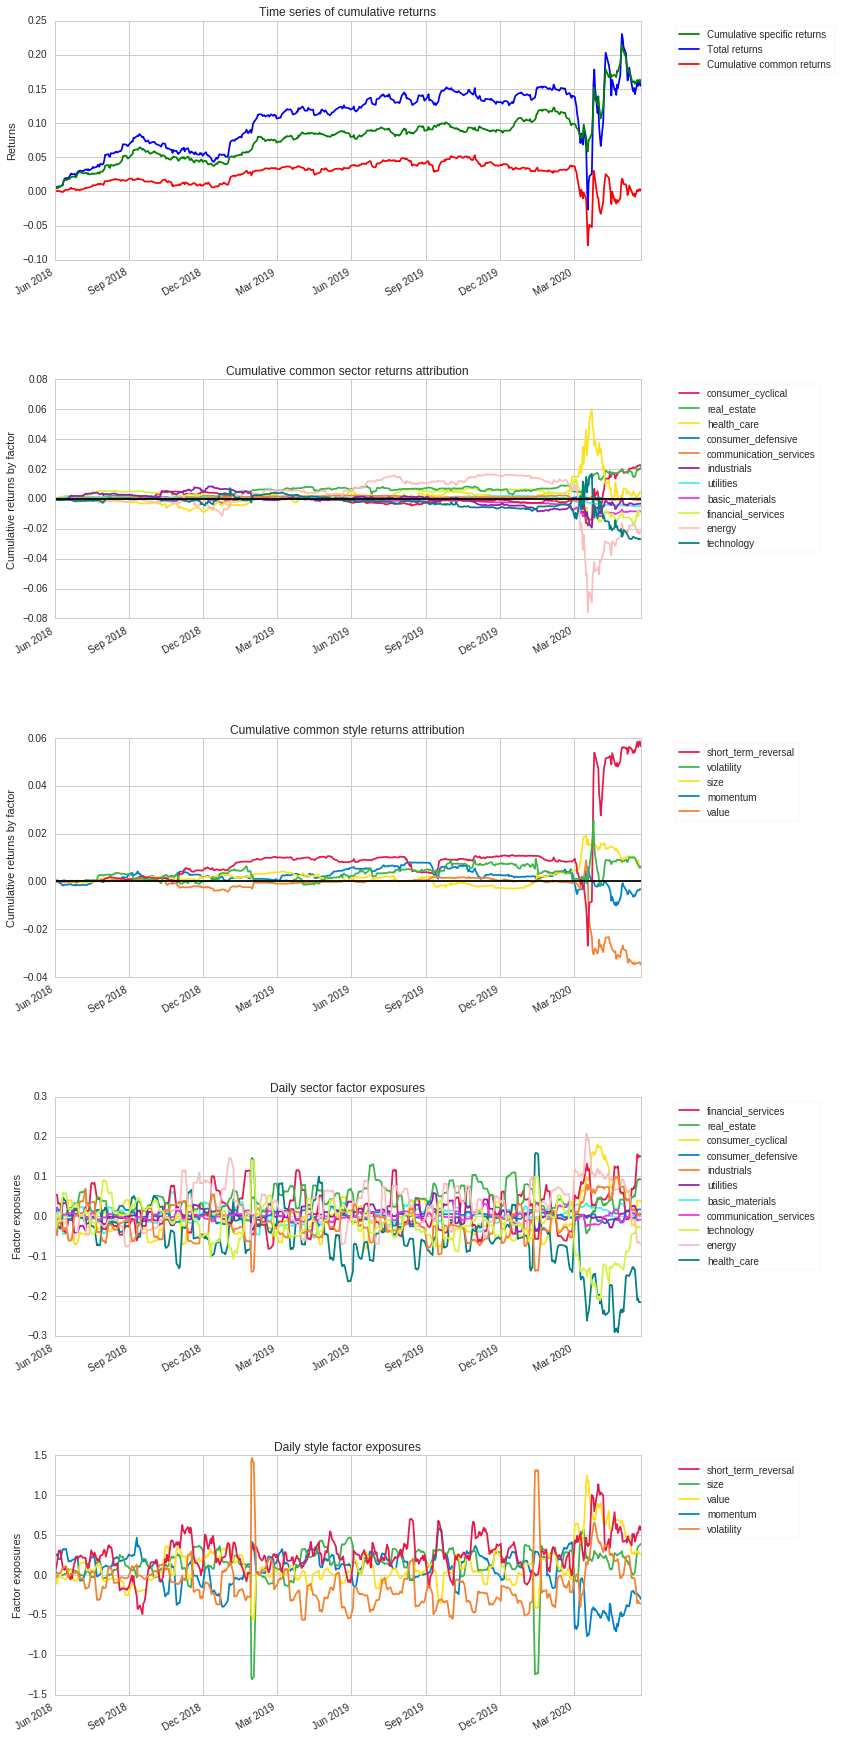

In [15]:
bt.create_full_tear_sheet(hide_positions=True, live_start_date='2019-07-01')